<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Описание проекта</a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Catboost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общие-выводы" data-toc-modified-id="Общие-выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общие выводы</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

### Описание проекта
Перед нами исторические данные о заказах такси в аэропортах. 

Задача: спрогнозировать количество заказов такси на следующий час.

Проанализируем данные и их временные ряды. Протестируем три модели, выберем лучшую.

## Подготовка

In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error, make_scorer

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df = df.sort_index(axis='index', ascending=True) # < напишите код здесь >
print(df.index.is_monotonic)
df.info()


True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
df.reset_index().duplicated().sum()

0

Проведем ресемплирование по одному часу.

In [4]:
df = df.resample('1H').sum()

In [5]:
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [6]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Видим, что после ресемплирования у нас стало в шесть раз меньше строк (так как десятиминутные отрезки мы соединили в часовые), и что мы располагаем данными за весну-лето 2018 года. Соответственно, элементы сезонности, повторяющиеся из года в год, мы увидеть не сможем. 

Данные подготовлены: проверены на дубликаты и пропуски, ресемплированы по 1 часу, переходим к анализу.

## Анализ

Данные приведены к необходимому виду. Перейдем к их анализу. Начнем с трендов и сезонности.

In [7]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


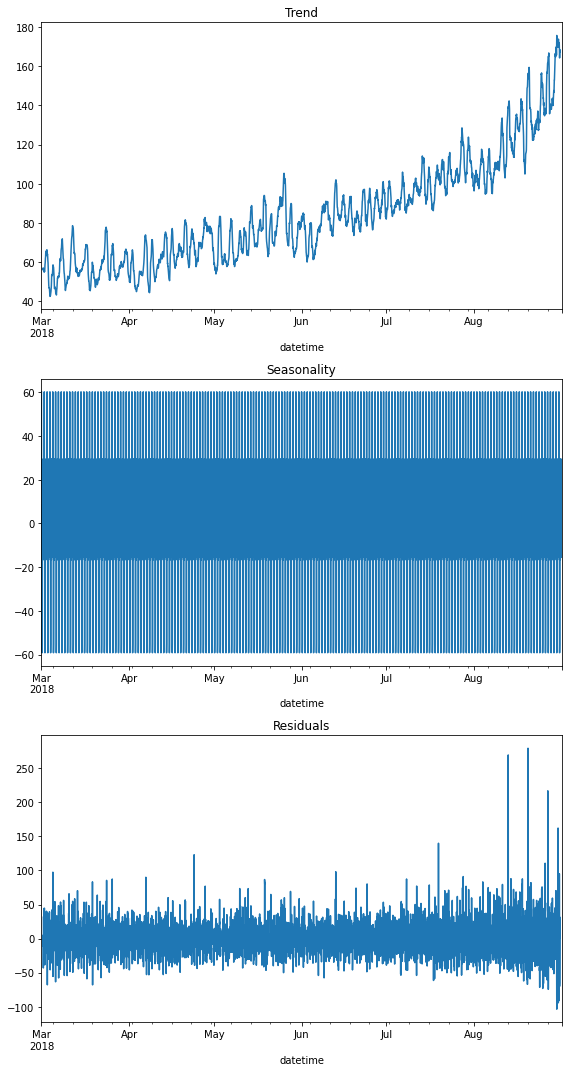

In [8]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(8, 15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

plt.title('Residuals')
plt.tight_layout()

Наблюдаем явный тренд на увеличение количества заказов с каждым новым месяцем. Сезонность рассмотрим на более узком временном участке в 2 недели.

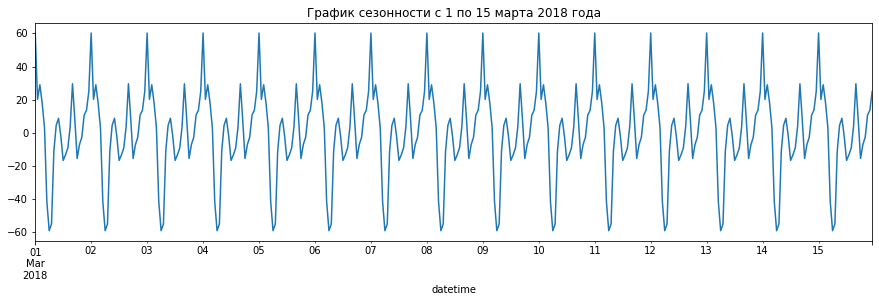

In [9]:
decomposed.seasonal['2018-03-01':'2018-03-15'].plot(figsize = (15,4), title='График сезонности с 1 по 15 марта 2018 года')
plt.show()

Уже понятнее: видим ежедневно 3 пика, включая самый высокий в районе перехода в новый день - вероятно, в районе полуночи. Посмотрим еще детальнее:

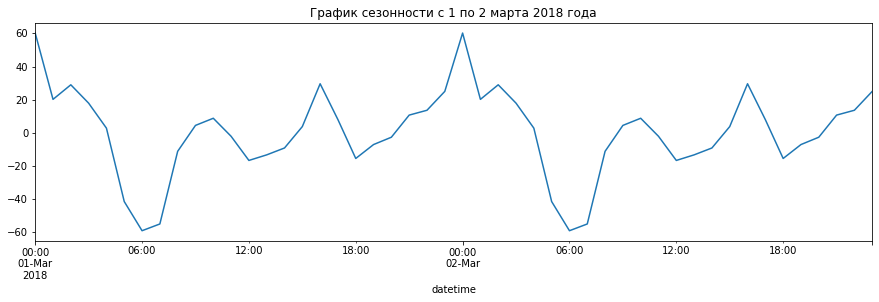

In [10]:
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(figsize = (15,4), title='График сезонности с 1 по 2 марта 2018 года')
plt.show()


По этому графику уже можно сделать более конкретные выводы:
1) Абсолютный минимум заказов такси в аэропорту - в районе 6 утра. Вероятно, связано с графиком прибывающих самолётов.

2) Первый пик - в районе 8-10 часов утра. Вероятно, прилетевшие пассажиры желают избежать часа пик в общественном транспорте с чемоданами или спешат на работу.

3) Похожая картина в районе 16 часов, объяснение про чемоданы и час пик может быть применено и здесь.

4) Абсолютный пик - в районе полуночи. Вероятно, общественный транспорт уже не ходит, а добираться из аэропорта как-то надо.

Предположим, что наряду с суточной сезонностью есть и недельная. Построим график, чтобы это проверить:

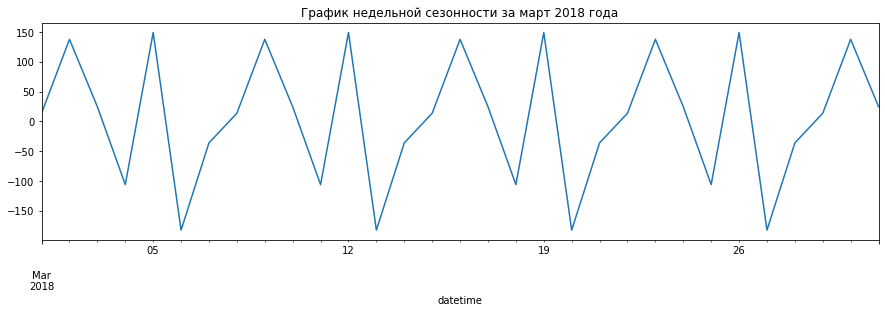

In [11]:
decomposed = seasonal_decompose(df.resample('1D').sum())
decomposed.seasonal['2018-03-01':'2018-03-31'].plot(figsize = (15,4), title='График недельной сезонности за март 2018 года')
plt.show()

Выводы по графику: 
- Наблюдается чёткая недельная сезонность.
- Самый нагруженный день - пятница, следом за ним понедельник и четверг. 
- Меньше всего заказов такси - во вторник и воскресенье.

## Обучение

В исходной таблице всего 1 столбец - количество заказов. Для обучения моделей необходимо создать дополнительные признаки. Для этого напишем функцию make_features(), в которую добавим:

1) Календарные признаки. Так как в нашей таблице содержатся только данные за полгода, то выделим следующие признаки: день недели, часы.

2) Предыдущие значения. Cоздадим столбцы с отстающими значениями с максимальным размером отставания в 5 часов.

3) Cкользящее среднее. Ранее мы выяснили, что пики заказов приходятся на промежутки по 2-4 часа. Поэтому зададим ширину окна в 3 часа. Помимо этого создадим скользящее среднее по дням (24 часа) и за 3 дня, так как ранее мы выявили недельную сезонность.



In [13]:
def make_features(data, max_lag, rolling_mean_size):
    frame = data.copy()
    frame['dayofweek'] = frame.index.dayofweek
    frame['hour'] = frame.index.hour
    
    for lag in range(1, max_lag + 1):
        frame['lag_{}'.format(lag)] = frame['num_orders'].shift(lag)

    frame['rolling_mean'] = frame['num_orders'].shift().rolling(rolling_mean_size).mean()
    frame['rolling_mean_24'] = frame['num_orders'].shift().rolling(24).mean()#скользящее среднее за сутки
    frame['rolling_mean_3days'] = frame['num_orders'].shift().rolling(72).mean()#скользящее среднее за 3 суток
    return frame

data = make_features(df, 5, 3)
print(data.head())

                     num_orders  dayofweek  hour  lag_1  lag_2  lag_3  lag_4  \
datetime                                                                       
2018-03-01 00:00:00         124          3     0    NaN    NaN    NaN    NaN   
2018-03-01 01:00:00          85          3     1  124.0    NaN    NaN    NaN   
2018-03-01 02:00:00          71          3     2   85.0  124.0    NaN    NaN   
2018-03-01 03:00:00          66          3     3   71.0   85.0  124.0    NaN   
2018-03-01 04:00:00          43          3     4   66.0   71.0   85.0  124.0   

                     lag_5  rolling_mean  rolling_mean_24  rolling_mean_3days  
datetime                                                                       
2018-03-01 00:00:00    NaN           NaN              NaN                 NaN  
2018-03-01 01:00:00    NaN           NaN              NaN                 NaN  
2018-03-01 02:00:00    NaN           NaN              NaN                 NaN  
2018-03-01 03:00:00    NaN     93.33333

Модели не смогут обрабатывать строки с пропусками, а нам нечем их заполнять. Придётся удалить.

In [14]:
data = data.dropna()

Добавим также столбец, содержащий разницу между количеством заказов в предыдущий и предшествующий тому часы:

In [15]:
data['lag_1-lag_2'] = data['lag_1']-data['lag_2']

Перейдем к разделению выборок.

In [16]:
train, test = train_test_split(data, test_size=0.1, shuffle=False)

In [17]:
#Проверка выборок
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-04 00:00:00 2018-08-13 20:00:00
2018-08-13 21:00:00 2018-08-31 23:00:00


Выборки разделены корректно, даты не перемешаны.

In [18]:
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

### Линейная регрессия

В качестве первой модели попробуем линейную регрессию.

In [19]:
%%time
lr = LinearRegression()
mse = cross_val_score(lr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

CPU times: user 47.9 ms, sys: 28.5 ms, total: 76.4 ms
Wall time: 29 ms


In [20]:
f"RMSE для линейной модели на валидационной выборке: {round((-mse.mean()) ** 0.5, 2)}"


'RMSE для линейной модели на валидационной выборке: 30.78'

In [21]:
%%time
lr = LinearRegression()
lr.fit(X_train, y_train)

CPU times: user 2.14 ms, sys: 3.63 ms, total: 5.76 ms
Wall time: 3.85 ms


LinearRegression()

In [22]:
%%time
predictions_lr = lr.predict(X_test)

CPU times: user 2.75 ms, sys: 0 ns, total: 2.75 ms
Wall time: 2.32 ms


In [23]:
mse_lr = mean_squared_error(y_test, predictions_lr)
f"RMSE для линейной модели на тестовой выборке: {round((mse_lr) ** 0.5, 2)}"

'RMSE для линейной модели на тестовой выборке: 50.03'

Линейная регрессия показала хорошие результаты на трейне, но не дотягивает до необходимого уровня на тестовой выборке. Попробуем подобрать ей гиперпараметры.

In [24]:
def rmse(predict, actual):
    predict = np.array(predict)
    actual = np.array(actual)

    distance = predict - actual

    square_distance = distance ** 2

    mean_square_distance = square_distance.mean()

    score = np.sqrt(mean_square_distance)

    return score

rmse_score = make_scorer(rmse, greater_is_better = False)

In [25]:
%%time
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
tscv = TimeSeriesSplit(n_splits=5)
grid_lr = GridSearchCV(lr, parameters, cv=tscv, scoring = rmse_score, verbose=False)
grid_lr.fit(X_train, y_train)
grid_lr.best_params_

CPU times: user 589 ms, sys: 312 ms, total: 901 ms
Wall time: 898 ms


{'copy_X': True, 'fit_intercept': False, 'normalize': True}

In [26]:
grid_lr.best_score_

-31.571706670134034

### Случайный лес

In [27]:
%%time
parameters = {'n_estimators': range(1, 8)}
             
random_forest = RandomForestRegressor(random_state=12345)
tscv = TimeSeriesSplit(n_splits=5)
grid_rf = GridSearchCV(random_forest, parameters, cv=tscv, scoring= 'neg_root_mean_squared_error')
grid_rf.fit(X_train, y_train)
grid_rf.best_params_

CPU times: user 1.89 s, sys: 0 ns, total: 1.89 s
Wall time: 1.89 s


{'n_estimators': 7}

In [28]:
grid_rf.best_score_

-26.125534161941182

Проверили n_estimators от 1 до 8 с помощью GridSearch, получили RMSE равный 26,1.

### Catboost

In [29]:
%%time
parameters = {'depth': range(1, 5),
            'iterations': range(1,5) }

             
catboost = CatBoostRegressor(random_state=12345, learning_rate=1)
train_pool = Pool(X_train, y_train)
tscv = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(catboost, parameters, cv=tscv, scoring = 'neg_root_mean_squared_error')
grid.fit(X_train, y_train)
grid.best_params_



0:	learn: 26.5234618	total: 46.3ms	remaining: 0us
0:	learn: 27.8552661	total: 412us	remaining: 0us
0:	learn: 29.1368784	total: 664us	remaining: 0us
0:	learn: 30.1865123	total: 571us	remaining: 0us
0:	learn: 31.2258640	total: 655us	remaining: 0us
0:	learn: 26.5234618	total: 299us	remaining: 299us
1:	learn: 24.0891026	total: 725us	remaining: 0us
0:	learn: 27.8552661	total: 510us	remaining: 510us
1:	learn: 26.1126097	total: 1.07ms	remaining: 0us
0:	learn: 29.1368784	total: 411us	remaining: 411us
1:	learn: 27.6434839	total: 947us	remaining: 0us
0:	learn: 30.1865123	total: 527us	remaining: 527us
1:	learn: 29.2264638	total: 1.16ms	remaining: 0us
0:	learn: 31.2258640	total: 586us	remaining: 586us
1:	learn: 30.4818022	total: 1.16ms	remaining: 0us
0:	learn: 26.5234618	total: 254us	remaining: 509us
1:	learn: 24.0891026	total: 660us	remaining: 330us
2:	learn: 22.8735346	total: 825us	remaining: 0us
0:	learn: 27.8552661	total: 332us	remaining: 664us
1:	learn: 26.1126097	total: 756us	remaining: 378u

{'depth': 4, 'iterations': 4}

In [30]:
grid.best_score_

-28.40741408196043

## Тестирование

Лучший результат на обучающей выборке показала модель случайного леса. Проверим ее на тестовых.

In [31]:
random_forest = RandomForestRegressor(random_state=12345, n_estimators=7)
random_forest.fit(X_train, y_train)
predictions = random_forest.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
rmse



46.150242155852936

Целевой показатель (RMSE=48) побит, модель удовлетворяет условиям проекта. 

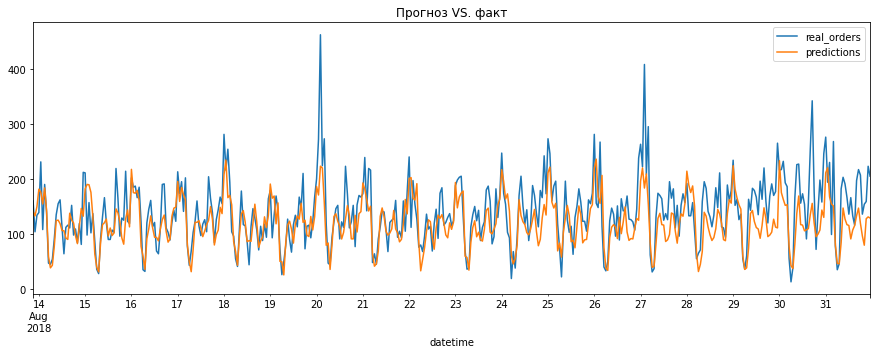

In [32]:
#Для наглядной интерпретации результатов выведем график реальных и предсказанных заказов:

taxi_predictions = pd.DataFrame()
taxi_predictions['real_orders'] = y_test
taxi_predictions['predictions'] = predictions
taxi_predictions.plot(figsize=(15,5), title='Прогноз VS. факт')
plt.show()

Модель слабовато предсказывает выбивающиеся из общего тренда пики (они для нее действительно неожиданны), но неплохо справляется со средними значениями. Почти никогда не предсказывает количество заказов больше, чем на самом деле: пока предложение не превышает спрос, таксопарк в минусе не останется :)

## Общие выводы

В работе над проектом мы:

- проанализировали датафрейм с временными рядами.

- выявили общий тренд - количество заказов такси увеличивается от месяца к месяцу.

- определили часовую сезонность: 3 пика заказов приходятся на периоды с 8 до 10,  с 15 до 17, в районе полуночи. Абсолютный минимум заказов приходится на раннее утро.

- выявили недельную сезонность: минимум заказов приходится на вторники и воскресенья, максимум - на понедельники и пятницы.

- создали для моделей дополнительные признаки: календарные (месяц, день, день недели, часы), предыдущие значения с  размером отставания в 1-5 часов, скользящие средние с шириной окна в 3 часа, по дням (24 часа) и за 3 дня. Дополнительно создали столбец, который содержит разницу между количеством заказов в предыдущий и предшествующий тому часы.

- обучили три различные модели: линейной регрессии, случайного леса и градиентного бустинга из библиотеки CatBoost.

Лучше всего на обучающей выборке справилась модель случайного леса в регрессии (25,2), хуже всего - модель линейной регрессии (30,5).
Лучшая модель (модель случайного леса в регрессии с n_estimators=7) на тестовой выборке показывает RMSE=46.15.